In [1]:
from IPython.display import display, HTML
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np # linear algebra
import numpy.matlib
from numpy.random import seed
import glob
import os
import gc
import copy

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupKFold,KFold

import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import probplot
import plotly.express as px

import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
revealed_targets = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_submission = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

In [3]:
df=train
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
df[['imbalance_size','imbalance_buy_sell_flag','reference_price','matched_size','far_price','near_price','bid_price','bid_size','ask_price','ask_size','wap','target']].describe()

,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06
mean,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02
std,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00
min,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02
25%,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00
50%,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02
75%,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00
max,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02


In [5]:
#对每个特征中相同元素个数进行统计
unnec = ["row_id"]
for col in train.columns:
    if col not in unnec:
        print(train[col].value_counts(), "\n")

stock_id
0      26455
137    26455
127    26455
128    26455
129    26455
       ...  
153    22605
199    21615
79     16500
135    15950
102    10230
Name: count, Length: 200, dtype: int64 

date_id
480    11000
353    11000
363    11000
362    11000
360    11000
       ...  
4      10560
2      10505
1      10505
3      10505
0      10505
Name: count, Length: 481, dtype: int64 

seconds_in_bucket
0      95236
410    95236
300    95236
310    95236
320    95236
330    95236
340    95236
350    95236
360    95236
370    95236
380    95236
390    95236
400    95236
420    95236
280    95236
430    95236
440    95236
450    95236
460    95236
470    95236
480    95236
490    95236
500    95236
510    95236
520    95236
530    95236
290    95236
270    95236
10     95236
130    95236
20     95236
30     95236
40     95236
50     95236
60     95236
70     95236
80     95236
90     95236
100    95236
110    95236
120    95236
140    95236
260    95236
150    95236
160    95236
170    95236

In [6]:
# check some first data
print("number of rows:", len(df))
print("number of columns:", len(df.columns))
print("number of unique stocks:", len(df['stock_id'].unique()))
print("number of unique date_id:", len(df['date_id'].unique()))
print("number of unique time_id:", len(df['time_id'].unique()))
print("number of unique row_id:", len(df['row_id'].unique()))
print("number of unique seconds_in_bucket:", len(df['seconds_in_bucket'].unique()))

number of rows: 5237980
number of columns: 17
number of unique stocks: 200
number of unique date_id: 481
number of unique time_id: 26455
number of unique row_id: 5237980
number of unique seconds_in_bucket: 55


In [7]:
#查看空值。输入基于神经网络的深度学习模型时NaN值可能会有问题需要填充。
print("Shape of the train data: ", train.shape)
print("Nulls: ", train.isna().sum())
null_cols = [col for col in train.columns if train[col].isna().sum()!=0]

Shape of the train data:  (5237980, 17)
Nulls:  stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64


In [8]:
#要预测的目标值，在竞赛网站对字段的描述中可以看到，是相对于指数的超额收益。target为400表示最后一分钟4%的超额收益
y_train = df['target']
y_train.describe().round(2)

count    5237892.00
mean          -0.05
std            9.45
min         -385.29
25%           -4.56
50%           -0.06
75%            4.41
max          446.07
Name: target, dtype: float64

Text(0.5, 1.0, 'Density Plot of Target')

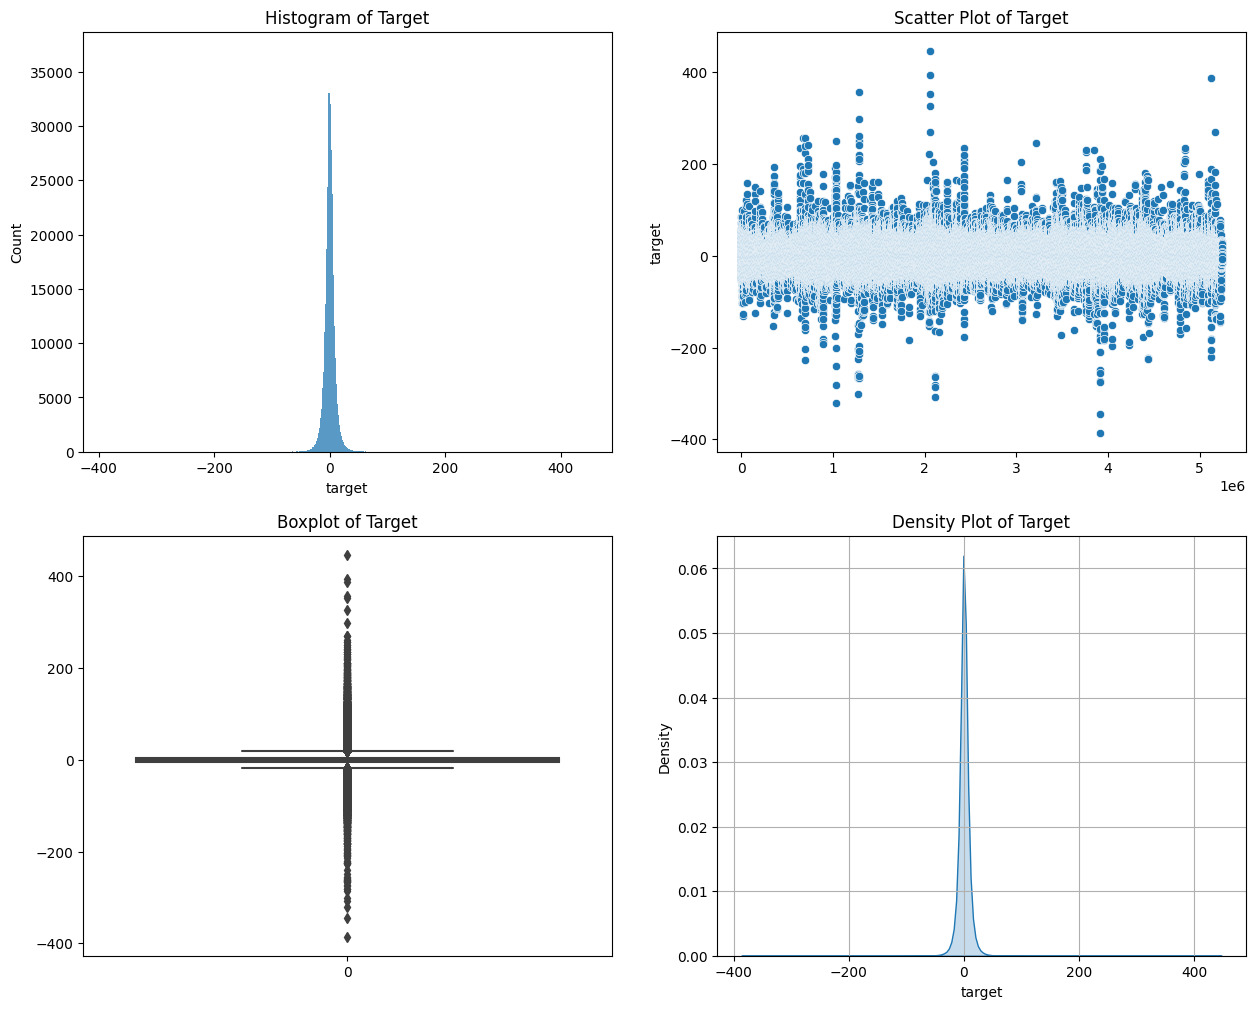

In [9]:
# 目标值平均值为-0.05，标准差9.45，25%/75%处于比较靠近中间的位置，但是存在极端值。
# 会出现极端值的原因是可以思考的。
# 论坛中有人认为stocks can diverge 4% sometimes in the last 60 seconds.
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,12))
plt.grid()
sns.set_style("whitegrid")
sns.histplot(train["target"], ax=axes[0,0])
axes[0,0].set_title("Histogram of Target")
sns.scatterplot(train["target"], ax=axes[0,1])
axes[0,1].set_title("Scatter Plot of Target")
sns.boxplot(train["target"], ax=axes[1,0])
axes[1,0].set_title("Boxplot of Target")
sns.kdeplot(train["target"], fill=True, ax=axes[1,1])
axes[1,1].set_title("Density Plot of Target")

Skew: 0.2047  -  Kurtosis: 22.5580


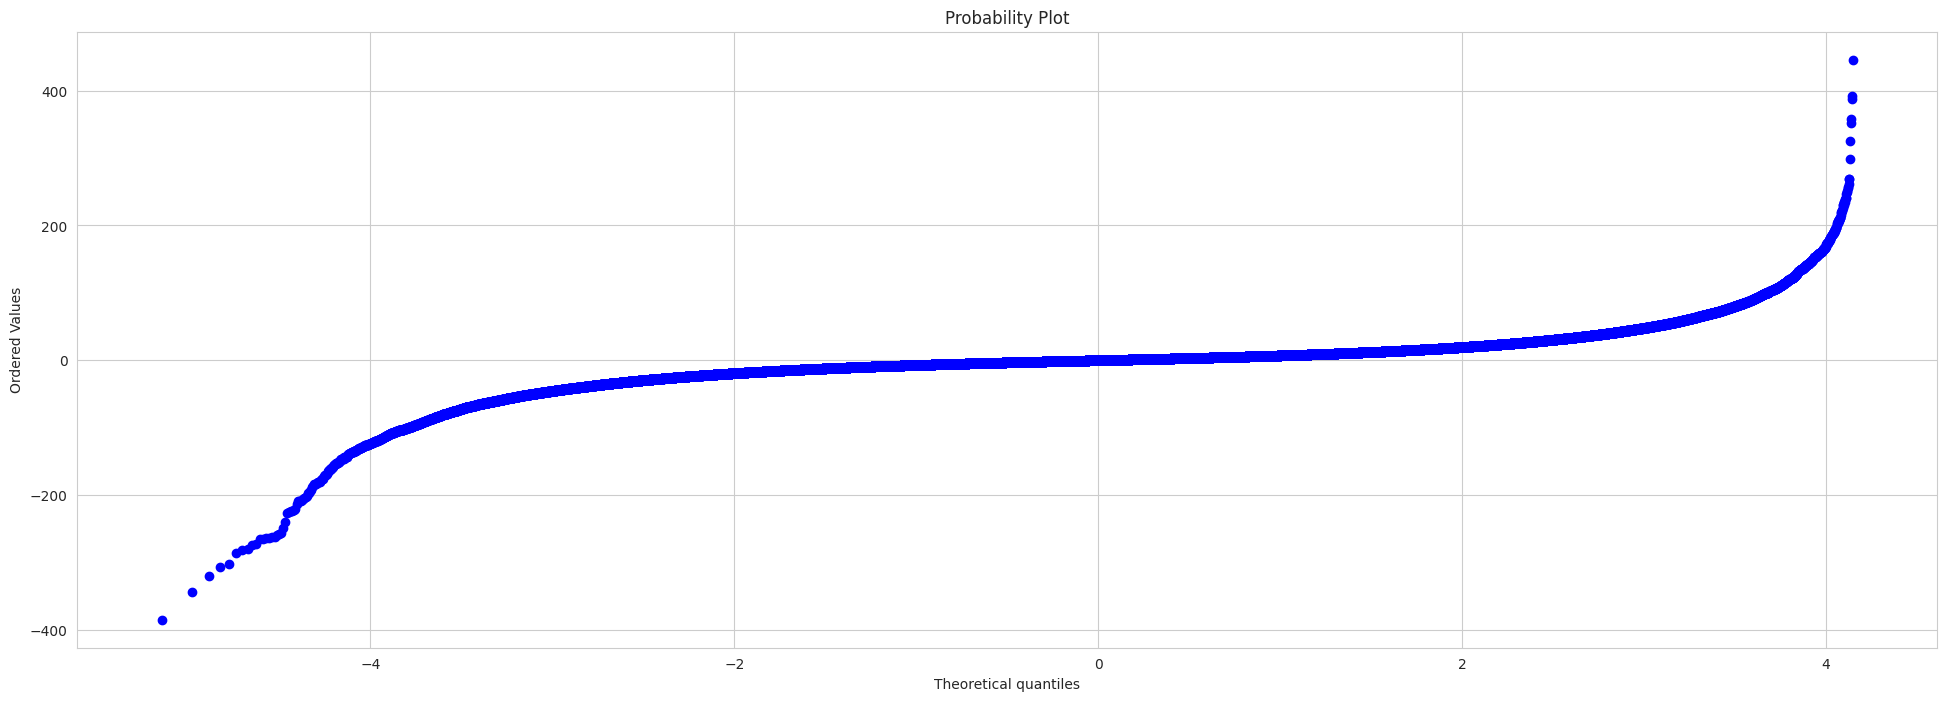

In [10]:
print(f'Skew: {train["target"].skew():.4f}  -  Kurtosis: {train["target"].kurtosis():.4f}')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(24, 8), dpi=100)
probplot(train["target"], plot=axes)
plt.show()
#target的概率密度分布

Text(0.5, 1.0, 'Scatter Plot of Target')

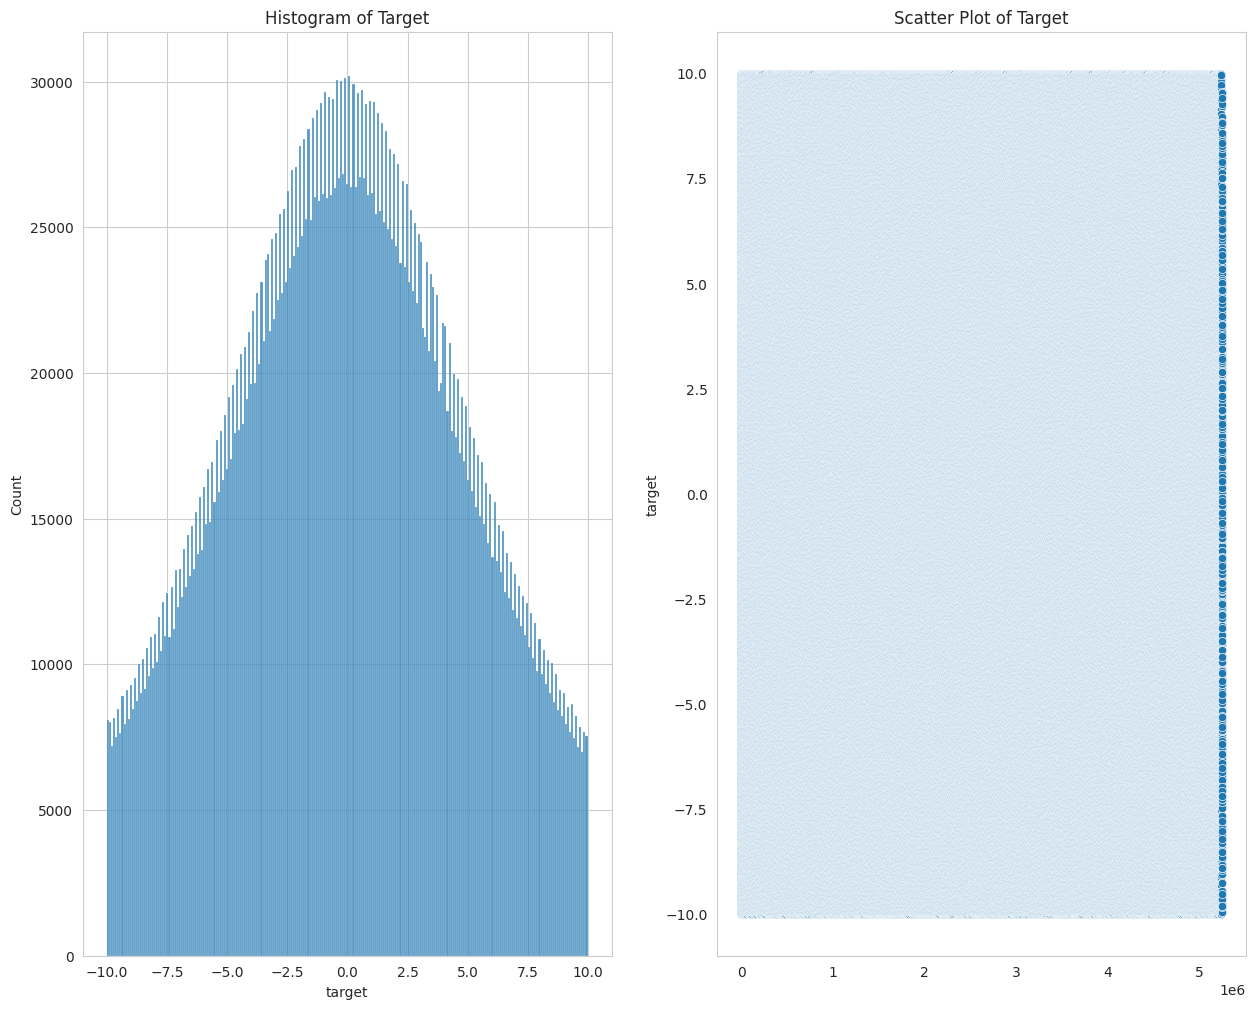

In [11]:
#选出比较靠近中间的target值看分布
train_target_selected=train[(train["target"]>-10) & (train["target"]<10)]
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,12))
plt.grid()
sns.set_style("whitegrid")
sns.histplot(train_target_selected["target"],ax=axes[0])
axes[0].set_title("Histogram of Target")
sns.scatterplot(train_target_selected["target"], ax=axes[1])
axes[1].set_title("Scatter Plot of Target")

In [12]:
#最大的一些目标值
df[df['target'].isin(df['target'].nlargest(5))]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
1283586,5,119,530,2913287.31,1,0.951448,42935205.93,0.958473,0.956466,0.952874,18040.00,0.953138,440839.35,0.952884,357.43950,6598,119_530_5
2052821,56,190,500,1538108.38,1,1.001289,22362265.92,1.006211,1.004128,1.001005,52880.00,1.001573,4338.62,1.001530,352.00000,10500,190_500_56
2053019,56,190,510,1576883.33,1,1.001100,22323490.97,1.006211,1.003844,1.000721,86381.41,1.001100,28346.36,1.001006,446.07043,10501,190_510_56
2053217,56,190,520,1697434.35,1,1.000058,22340289.93,1.005643,1.003371,0.999585,21122.00,1.000437,3171.00,1.000326,392.88043,10502,190_520_56
5117011,31,470,0,5874339.88,1,0.997387,8867263.02,NaN,NaN,0.997387,10264.56,1.006136,24309.85,1.000000,387.77948,25850,470_0_31


In [13]:
#最小的一些目标值
df[df['target'].isin(df['target'].nsmallest(5))]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
1030016,174,96,300,15596888.65,-1,1.024768,3.906302e+08,1.023542,1.023542,1.020069,9985.00,1.024666,10030.00,1.022367,-319.75986,5310,96_300_174
1276100,5,119,150,587655.56,1,0.999039,1.845284e+07,NaN,NaN,0.997295,94405.00,0.999355,19109.20,0.999009,-302.23013,6560,119_150_5
2115316,70,196,340,13708.21,-1,1.007232,7.370596e+06,1.001626,1.007232,1.007232,13354.65,1.007633,8327.96,1.007479,-307.45030,10814,196_340_70
3908722,142,360,80,22512332.60,1,1.000688,1.041552e+08,NaN,NaN,1.000264,10030.68,1.000807,37783.04,1.000378,-385.28980,19808,360_80_142
3909122,142,360,100,21407479.89,1,1.000298,1.053804e+08,NaN,NaN,0.999892,41287.40,1.000231,4720.16,1.000196,-343.89020,19810,360_100_142


In [14]:
# 95%分位数和5%分位数，为正负十四
df['target'].quantile(0.05),df['target'].quantile(0.95)

(-14.050007, 13.959408)

In [15]:
#有一部分目标值是NAN
df[df['target'].isna()]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225338,158,388,510,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21391,388_510_158
4225538,158,388,520,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21392,388_520_158
4225738,158,388,530,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21393,388_530_158
4225938,158,388,540,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21394,388_540_158


会出现这种情况原因不明，可能是因为该stock_id在那个date_id中就没有交易。这种情况在4个(date_id,stock_id)中出现。

In [16]:
df[df['target'].isna()]['stock_id'].unique()
df[df['target'].isna()]['date_id'].unique()

array([ 35, 328, 388, 438])

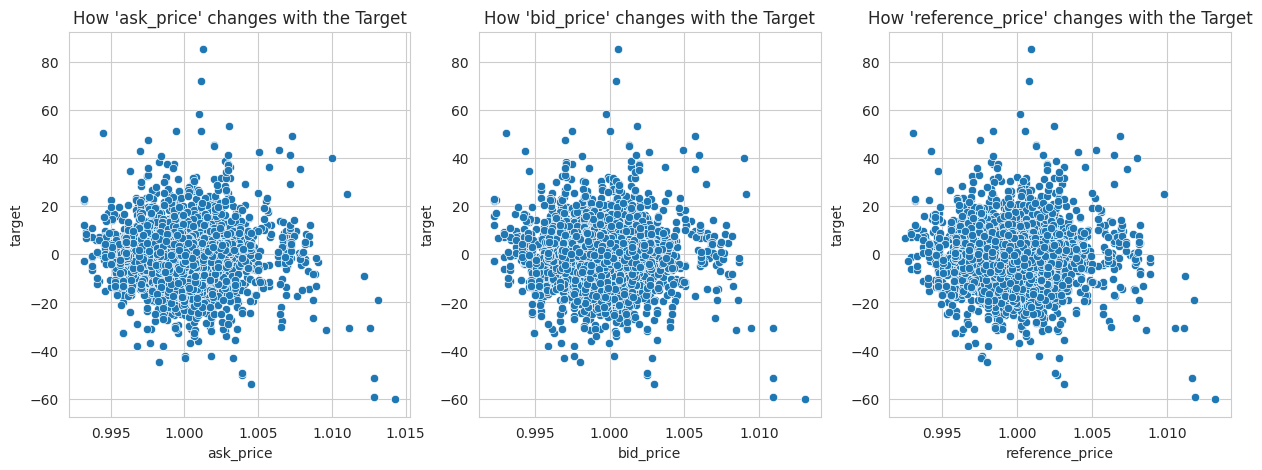

In [17]:
#观察其他特征相对于target的分布
n_selected=10000
plot_cols = ["ask_price", "bid_price","reference_price"]
fig, axes = plt.subplots(1,3, figsize=(15,5))
for col, axe in zip(plot_cols, axes):
    sns.scatterplot(x=train[col][:n_selected], y=train["target"][:n_selected], ax=axe)
    axe.set_title(f"How '{col}' changes with the Target")

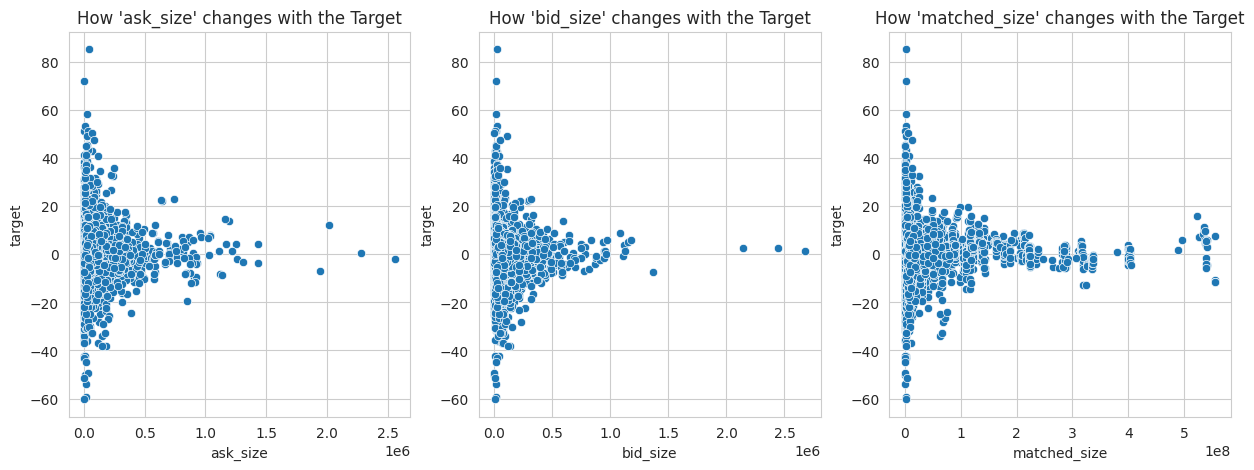

In [18]:
plot_cols = ["ask_size", "bid_size","matched_size"]
fig, axes = plt.subplots(1,3, figsize=(15,5))
for col, axe in zip(plot_cols, axes):
    sns.scatterplot(x=train[col][:n_selected], y=train["target"][:n_selected], ax=axe)
    axe.set_title(f"How '{col}' changes with the Target")

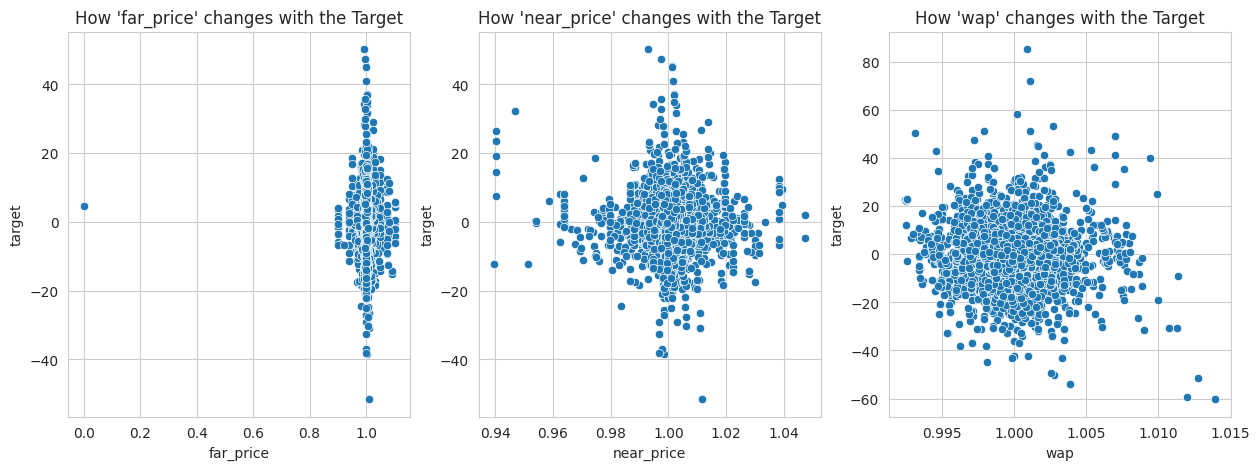

In [19]:
plot_cols = ["far_price", "near_price","wap"]
fig, axes = plt.subplots(1,3, figsize=(15,5))
for col, axe in zip(plot_cols, axes):
    sns.scatterplot(x=train[col][:n_selected], y=train["target"][:n_selected], ax=axe)
    axe.set_title(f"How '{col}' changes with the Target")

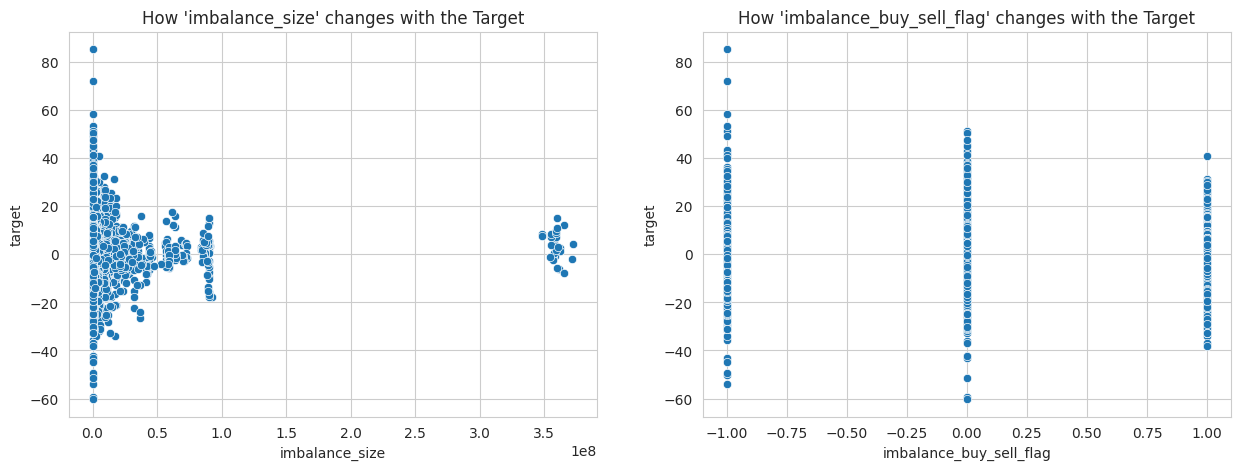

In [20]:
plot_cols = ["imbalance_size", "imbalance_buy_sell_flag"]
fig, axes = plt.subplots(1,2, figsize=(15,5))
for col, axe in zip(plot_cols, axes):
    sns.scatterplot(x=train[col][:n_selected], y=train["target"][:n_selected], ax=axe)
    axe.set_title(f"How '{col}' changes with the Target")

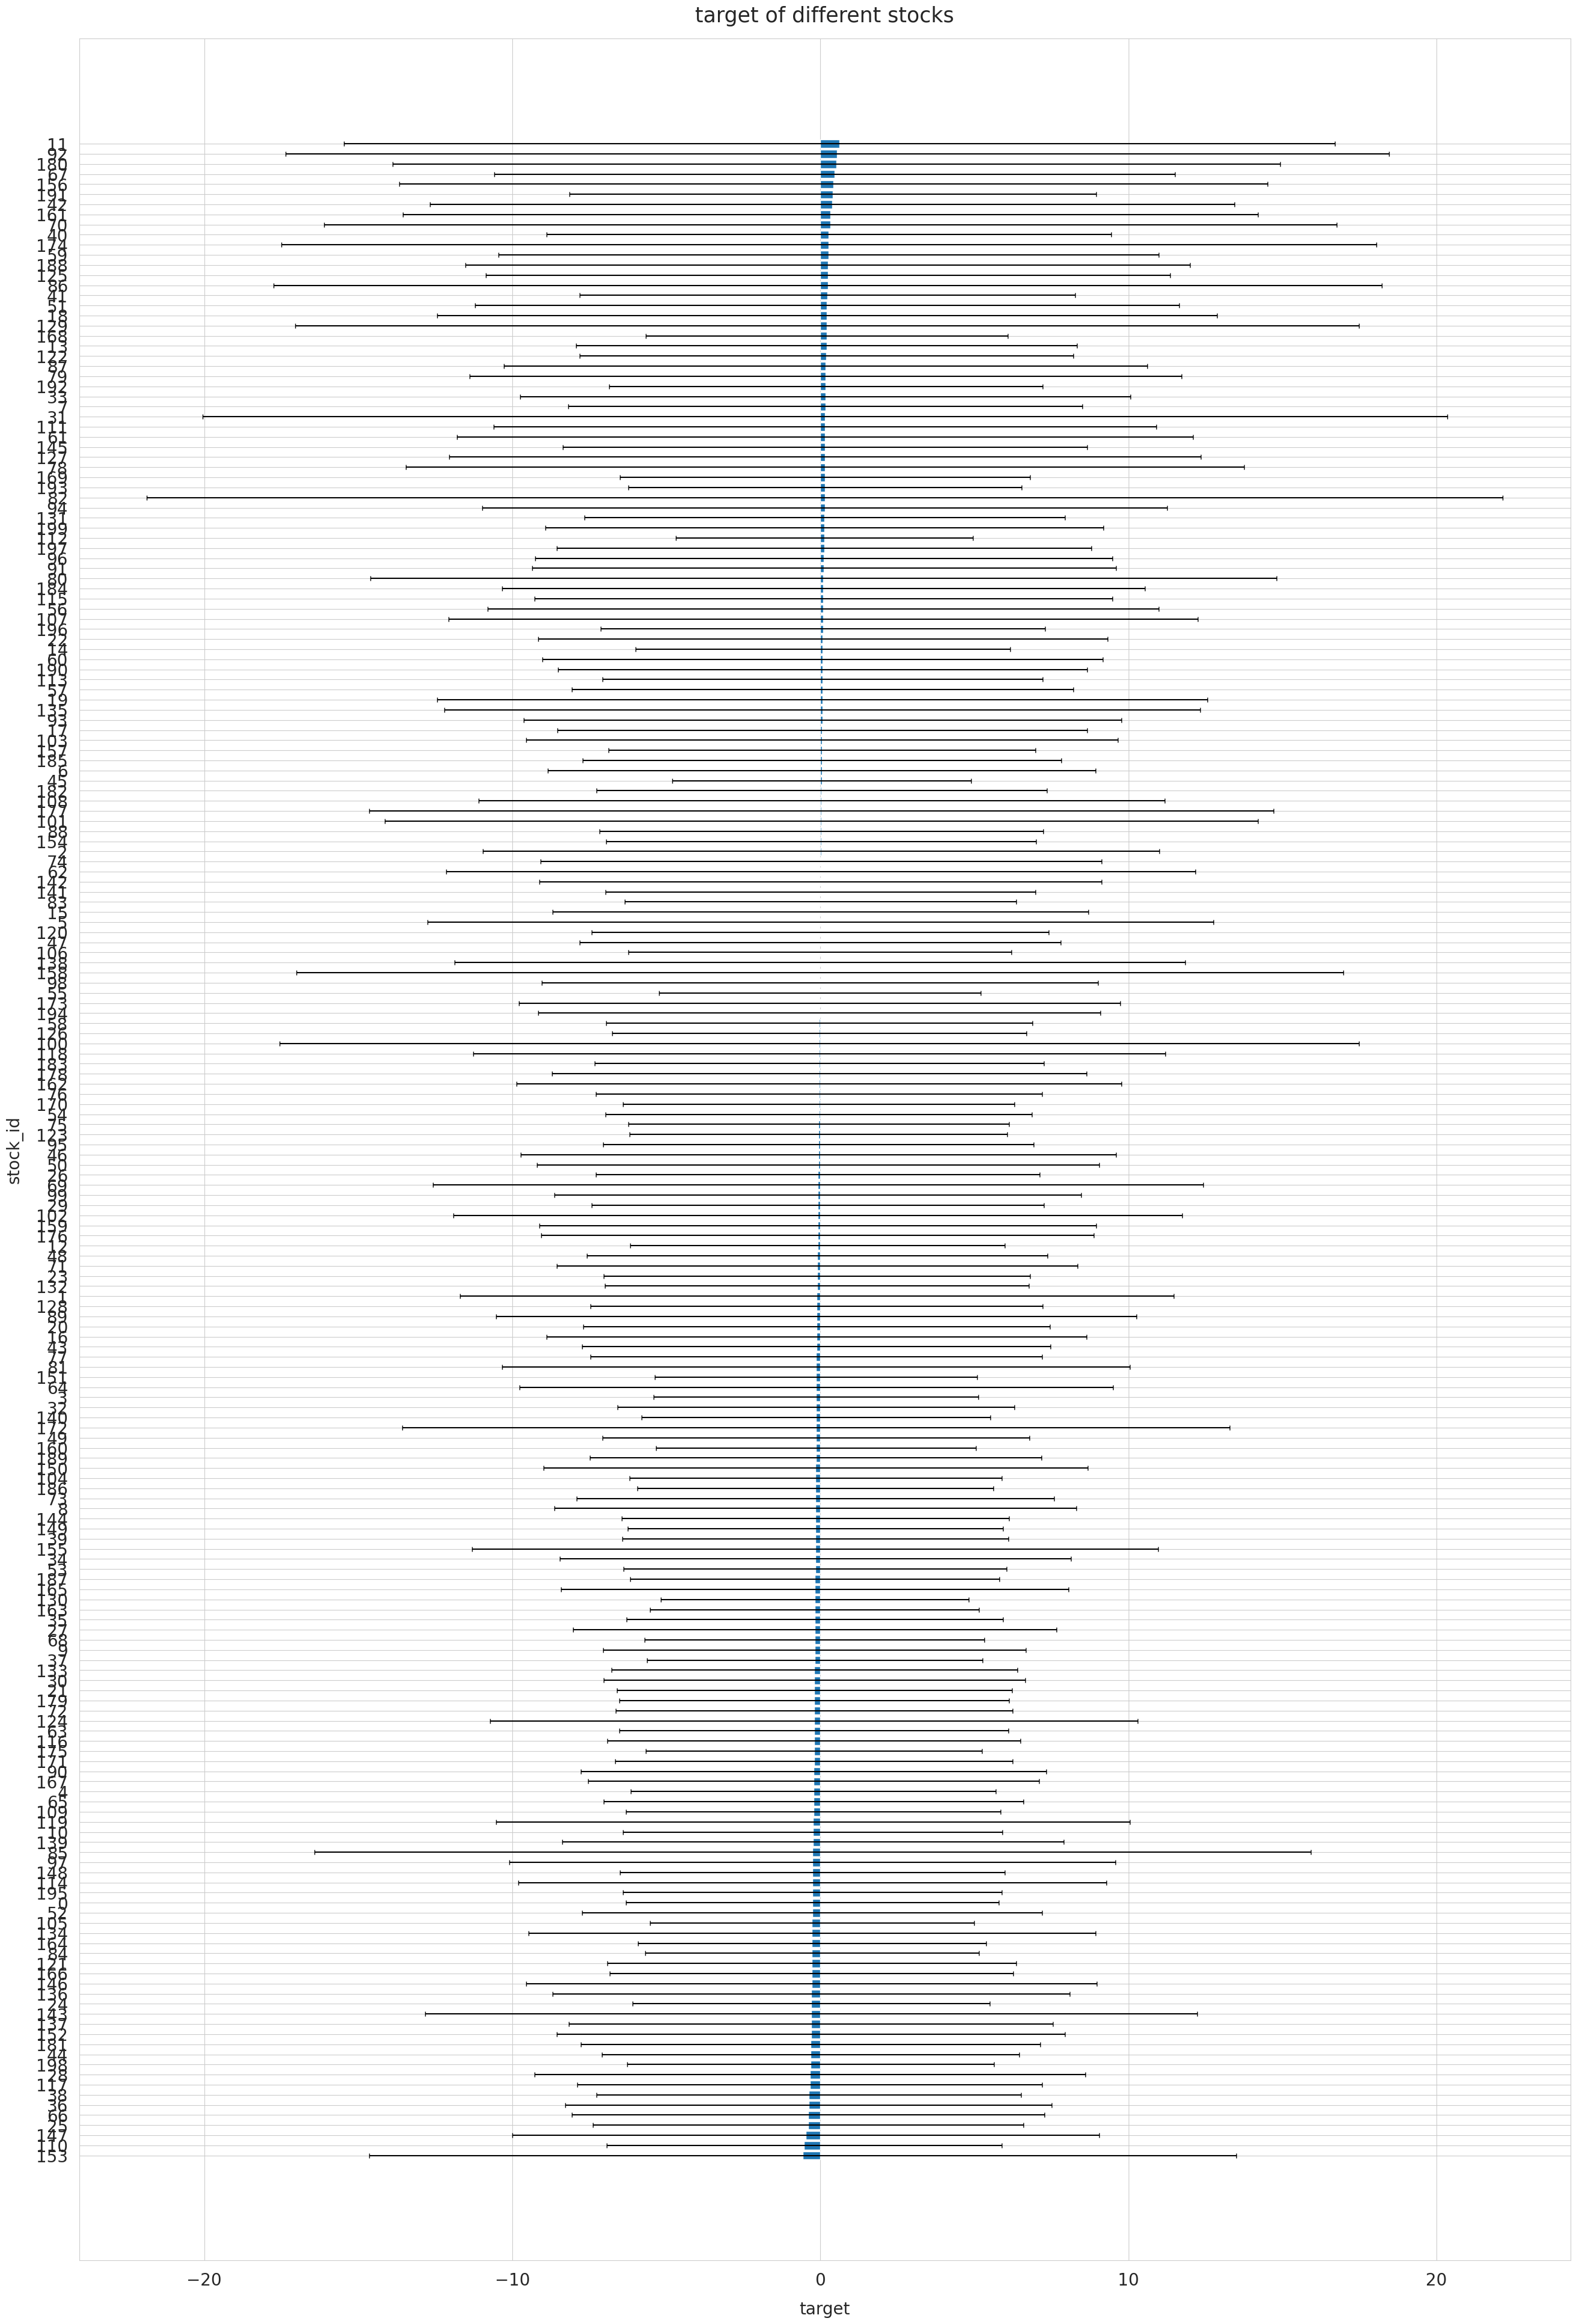

In [21]:
#不同股票的目标值的均值和方差情况，蓝色表示均值，黑色中线表示方差
target_means = train.groupby('stock_id')['target'].mean()
target_stds = train.groupby('stock_id')['target'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)), 
    width=target_means_and_stds['mean'],  #主体长度
    xerr=target_means_and_stds['std'],    #指定误差大小，用于在条形图上添加误差线
    align='center',    
    ecolor='black',    #指定误差线的颜色
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('target of different stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds

#可以看到存在一些非常不稳定的股票，它们有异常高的波动率。

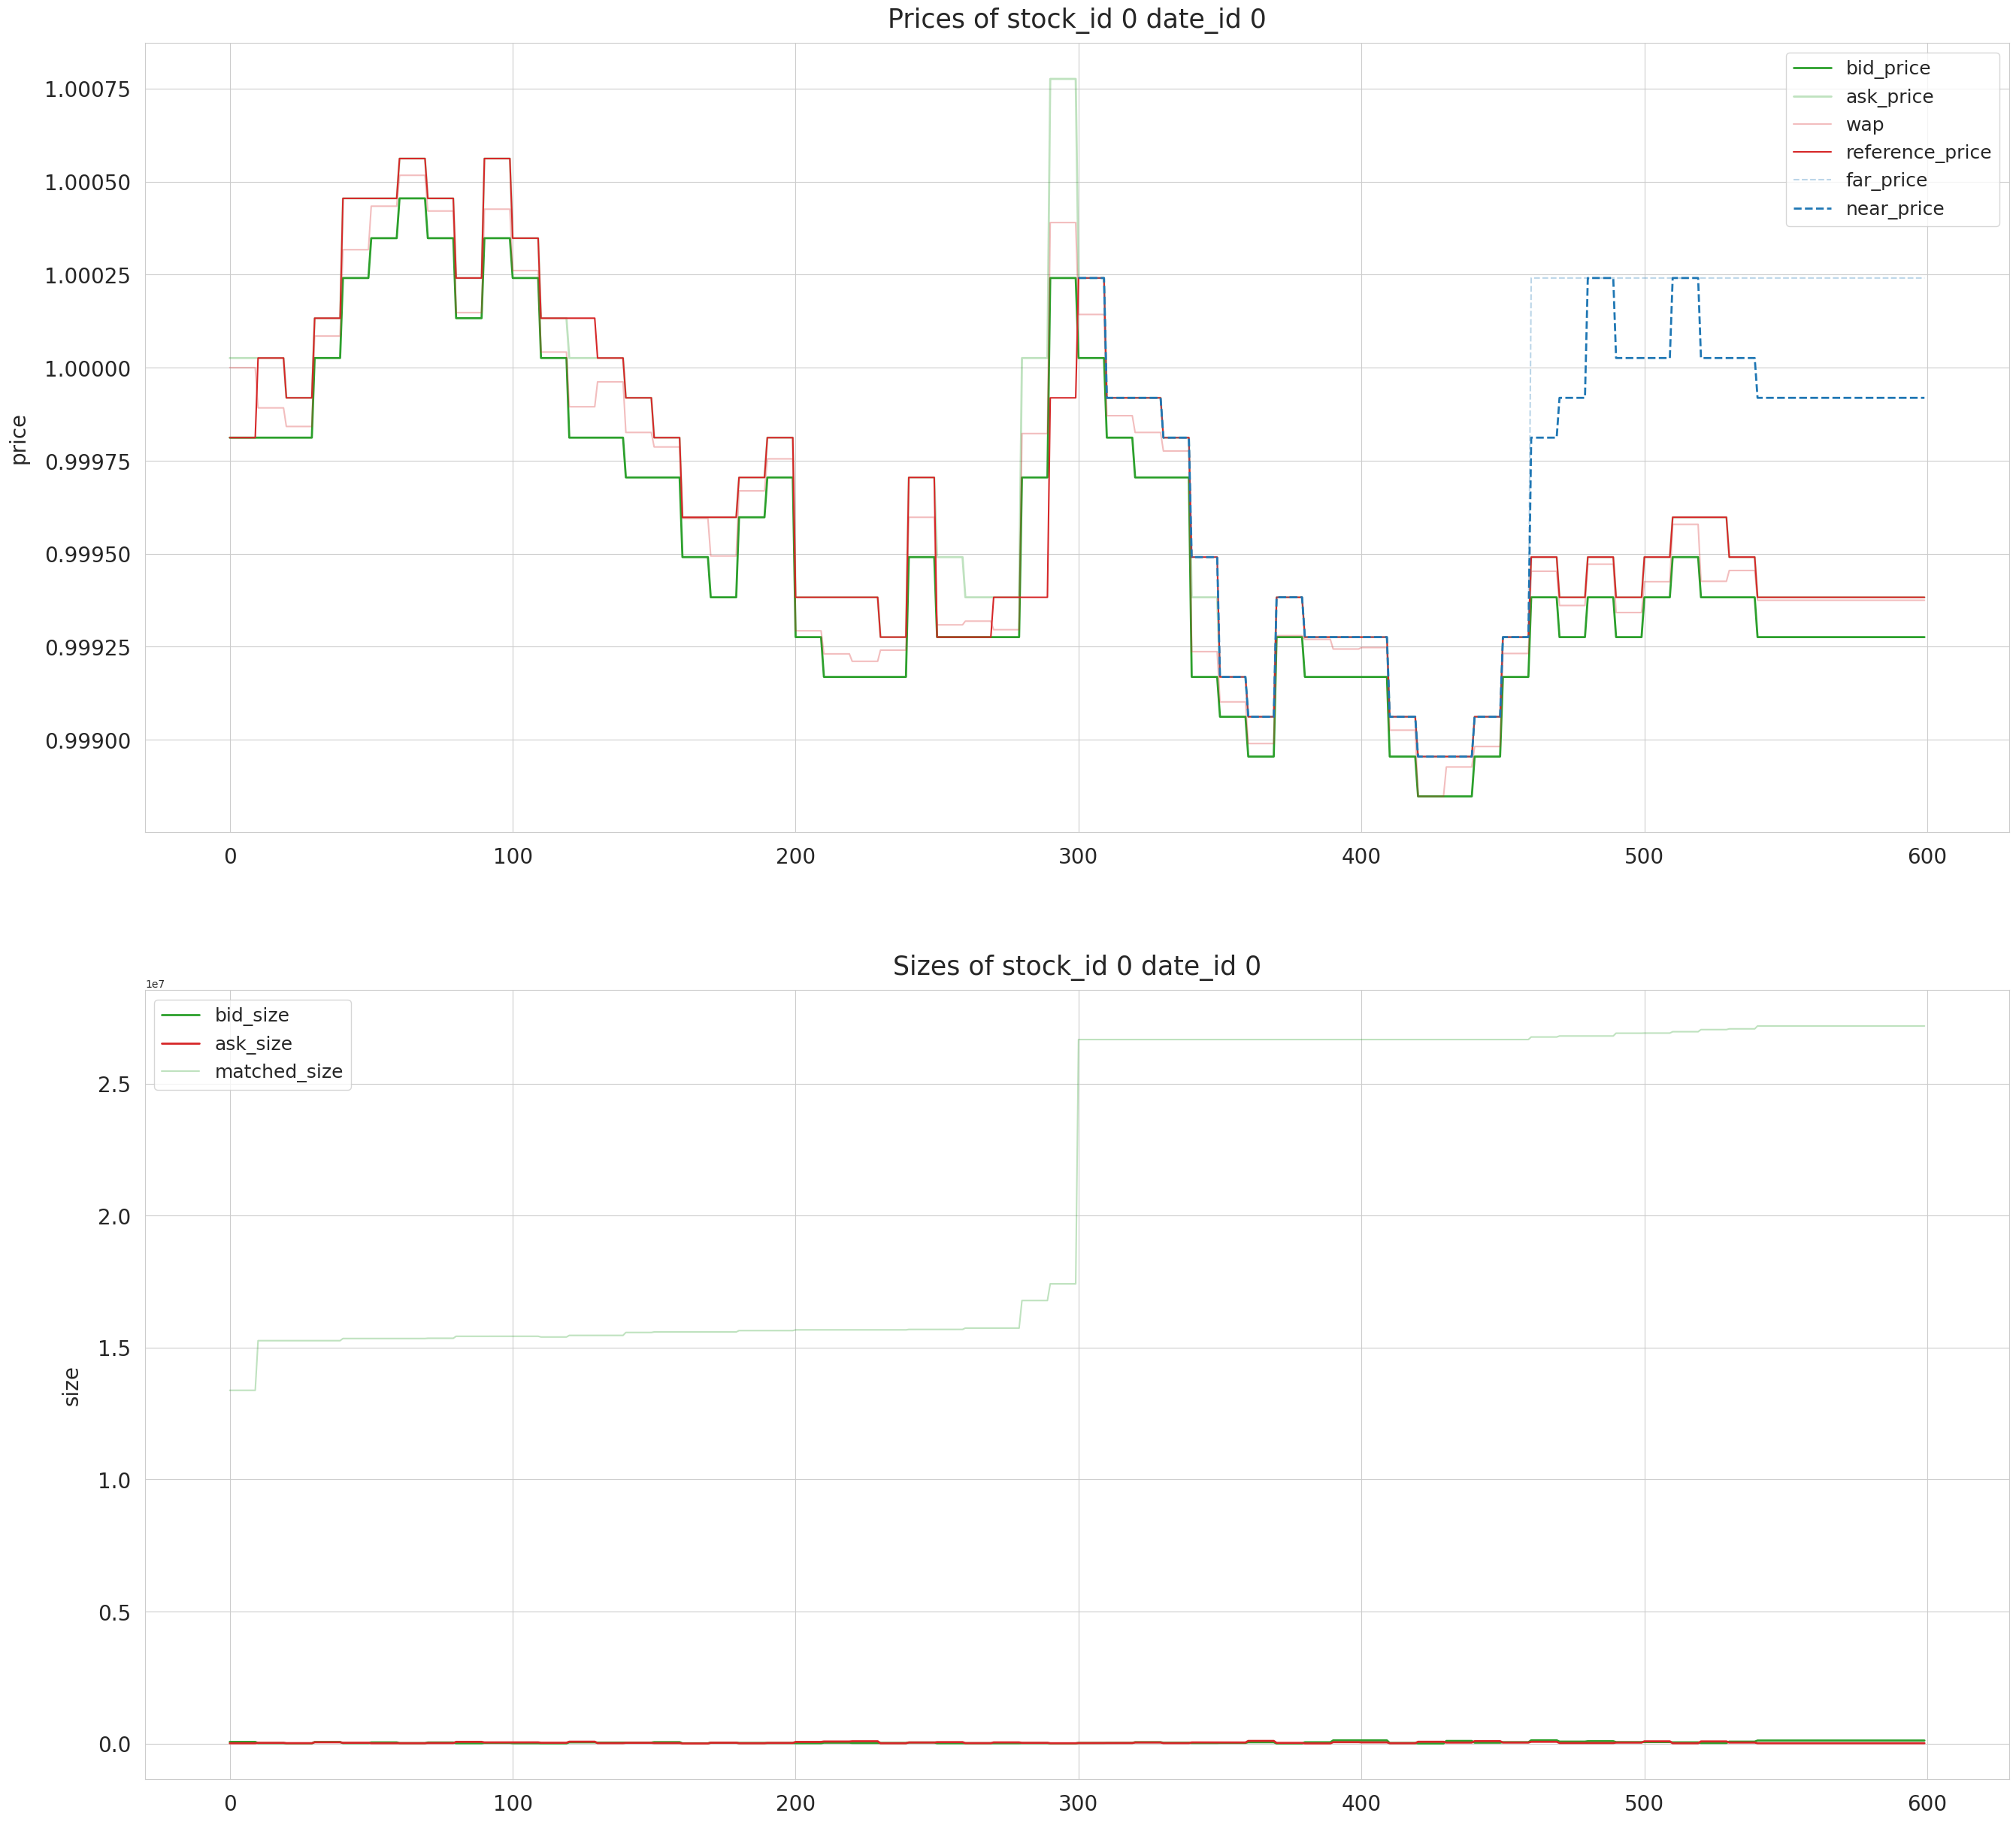

In [22]:
#使用 visualize_book_time_bucket 函数可视化单个股票在一个date_id中的各个订单价格和订单大小
def visualize_book_time_bucket(stock_id, date_id):   
    time_bucket = (train['stock_id'] == stock_id) & (train['date_id'] == date_id)
    df_book = train[time_bucket]
    df_book.sort_values(by=['seconds_in_bucket'], inplace=True)
    #如果需要前向填充
    df_book = df_book.set_index(['date_id', 'seconds_in_bucket'])
    df_book = df_book.reindex(pd.MultiIndex.from_product([df_book.index.levels[0], np.arange(0, 600)], names=['date_id', 'seconds_in_bucket']), method='ffill')
    df_book.reset_index(inplace=True)
    
    df_book = df_book.set_index('seconds_in_bucket')

    
    fig, axes = plt.subplots(figsize=(32, 30), nrows=2)
    
    axes[0].plot(df_book.loc[:, 'bid_price'], label='bid_price', lw=2, color='tab:green')
    axes[0].plot(df_book.loc[:, 'ask_price'], label='ask_price', lw=2, alpha=0.3, color='tab:green')
    axes[0].plot(df_book.loc[:, 'wap'], label='wap', alpha=0.3, color='tab:red')
    axes[0].plot(df_book.loc[:, 'reference_price'], label='reference_price', color='tab:red')
    axes[0].plot(df_book.loc[:, 'far_price'], label='far_price', alpha=0.3, linestyle='--',  color='tab:blue')
    axes[0].plot(df_book.loc[:, 'near_price'], label='near_price', lw=2, linestyle='--', color='tab:blue')
   
    axes[1].plot(df_book.loc[:, 'bid_size'], label='bid_size', lw=2, color='tab:green')
    axes[1].plot(df_book.loc[:, 'ask_size'], label='ask_size', lw=2, color='tab:red')
    axes[1].plot(df_book.loc[:, 'matched_size'], label='matched_size', alpha=0.3, color='tab:green')
   
    for i in range(2):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('size', size=20, labelpad=15)
    
    axes[0].set_title(
        f'Prices of stock_id {stock_id} date_id {date_id}',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Sizes of stock_id {stock_id} date_id {date_id}',
        size=25,
        pad=15
    )
    
    plt.show()
    

visualize_book_time_bucket(stock_id=0, date_id=0)
#可以对其他的stock_id和date_id进行可视化

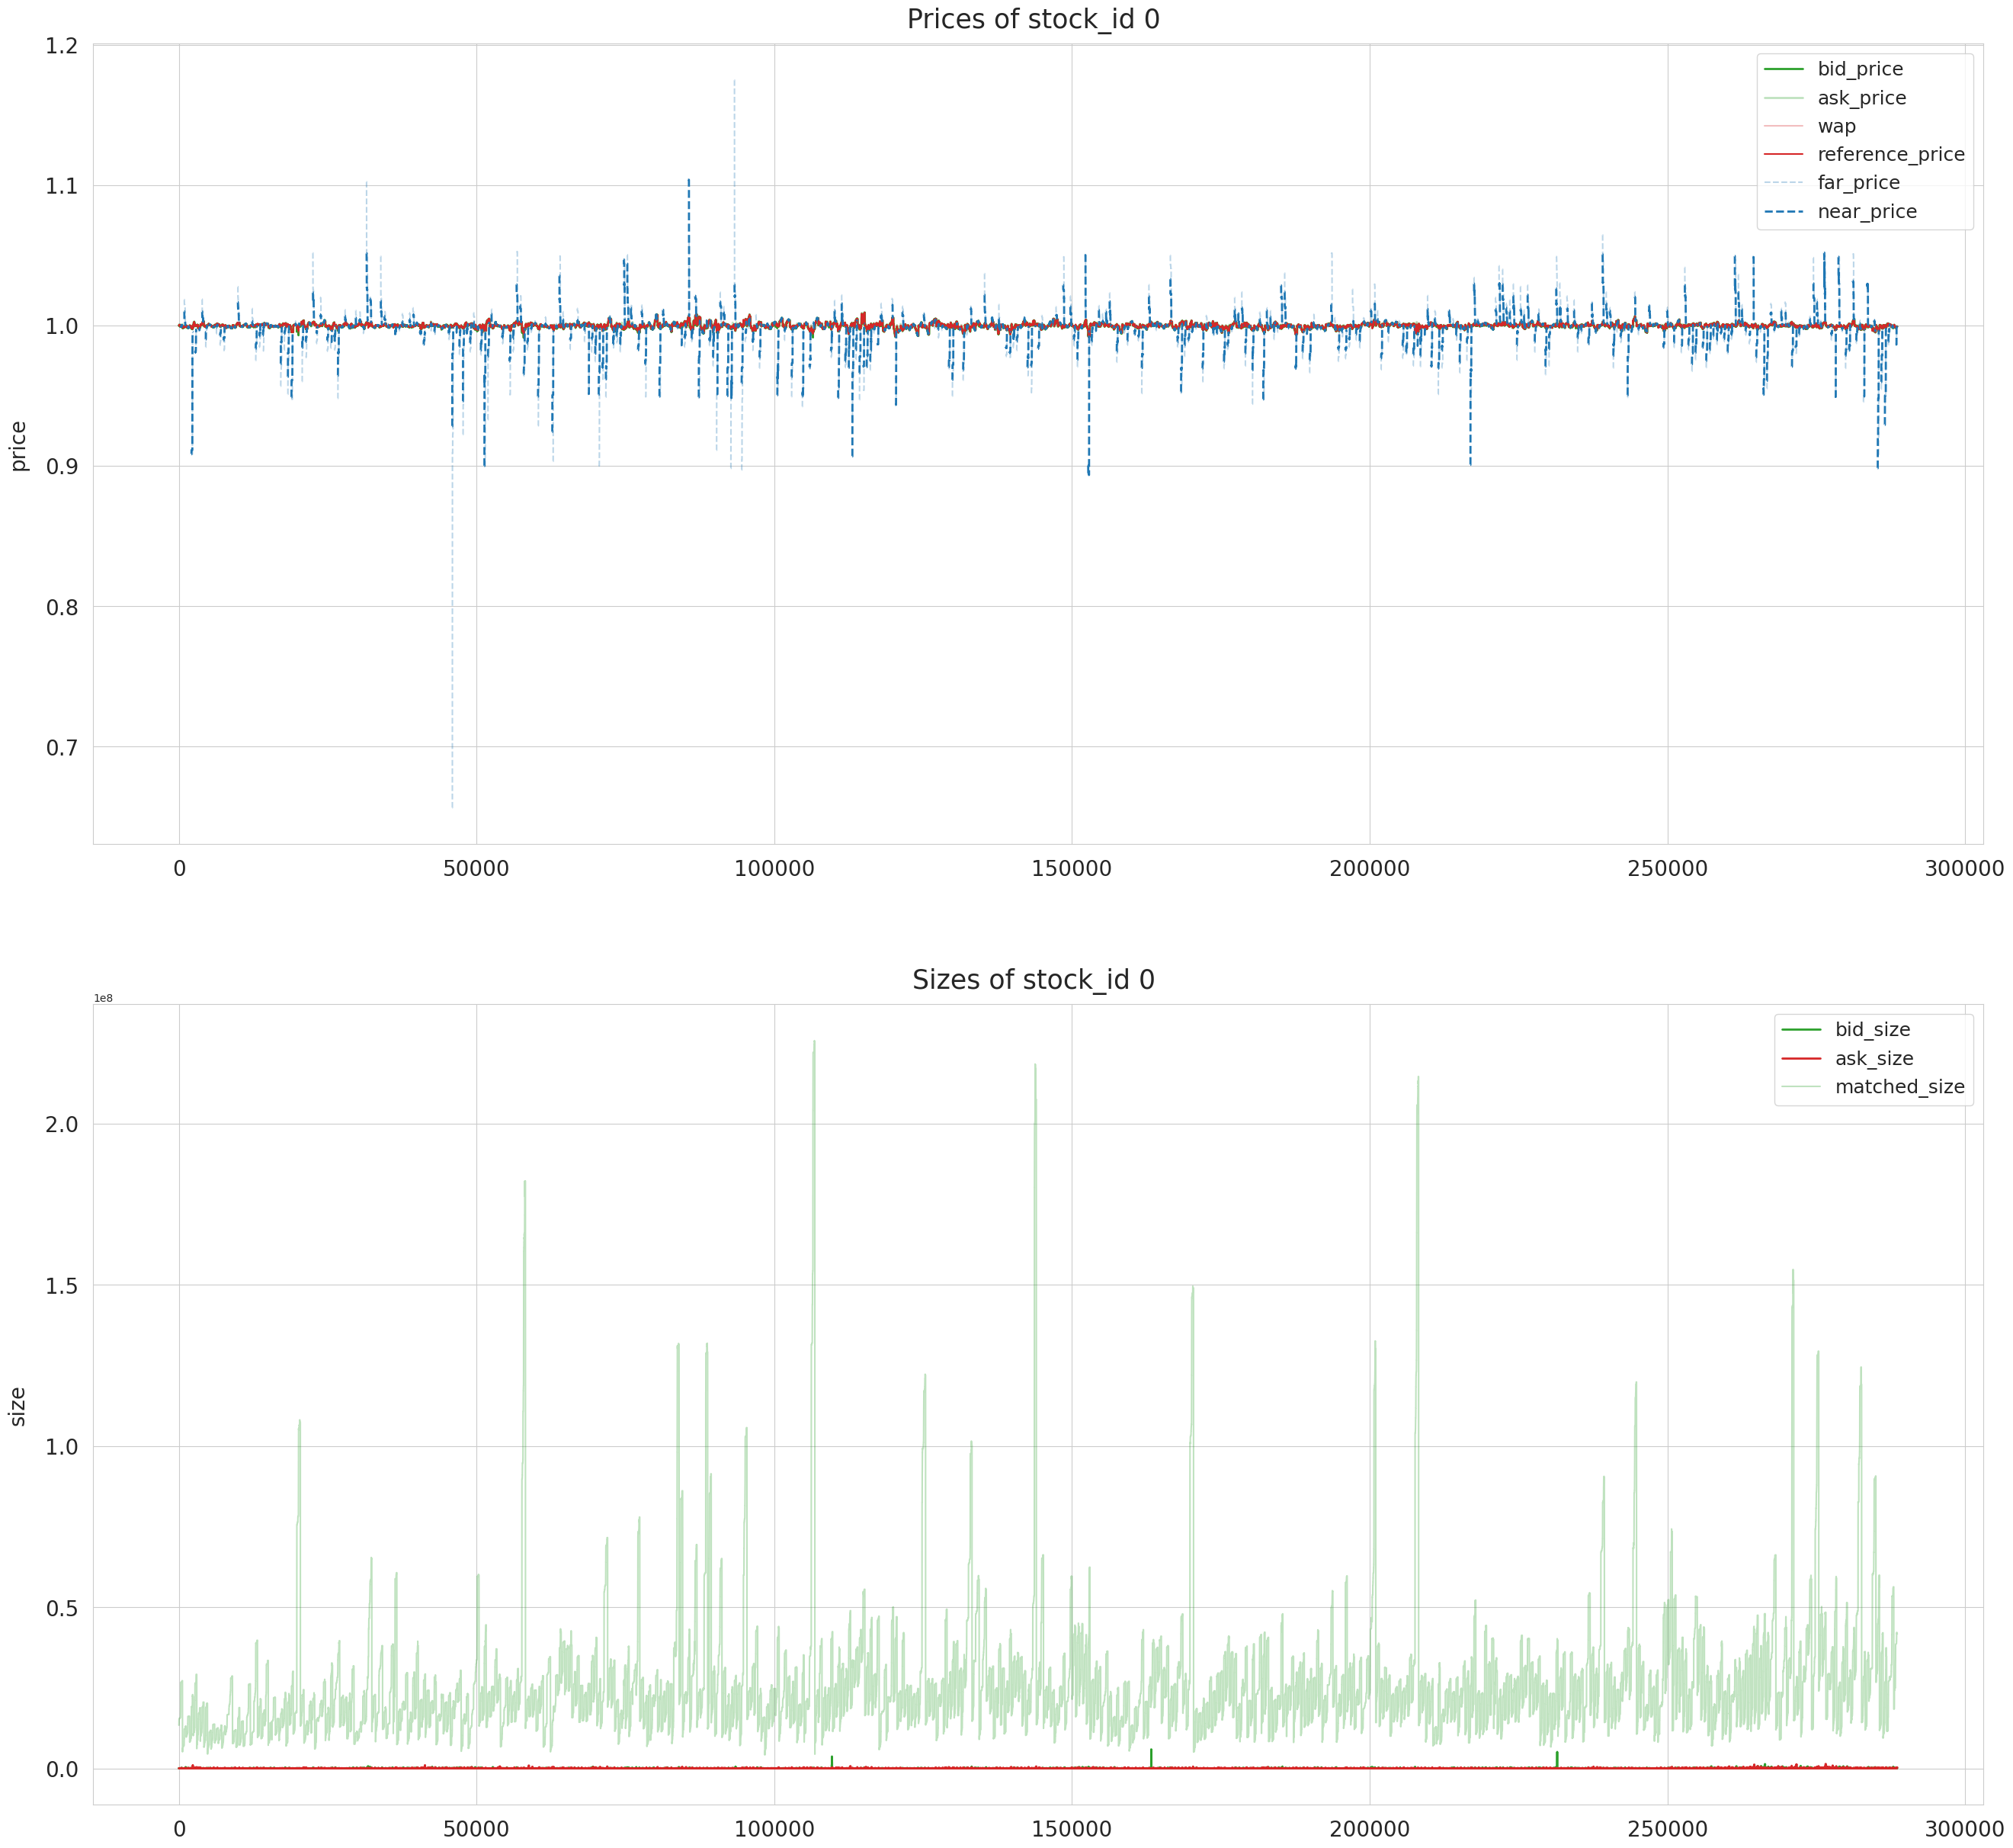

In [23]:
#使用 visualize_all_date_id 函数可视化单个股票在所有时间中的各个订单价格和订单大小
def visualize_all_date_id(stock_id):   
    time_bucket = (train['stock_id'] == stock_id)
    df_book = train[time_bucket]
    df_book.sort_values(by=['date_id','seconds_in_bucket'], inplace=True)
    #如果需要前向填充
    df_book = df_book.set_index(['date_id', 'seconds_in_bucket'])
    df_book = df_book.reindex(pd.MultiIndex.from_product([df_book.index.levels[0], np.arange(0, 600)], names=['date_id', 'seconds_in_bucket']), method='ffill')
    df_book.reset_index(inplace=True)
    
    df_book['new_time_index']=df_book['date_id']*600+df_book['seconds_in_bucket']
    df_book = df_book.set_index('new_time_index')

    
    fig, axes = plt.subplots(figsize=(32, 30), nrows=2)
    
    axes[0].plot(df_book.loc[:, 'bid_price'], label='bid_price', lw=2, color='tab:green')
    axes[0].plot(df_book.loc[:, 'ask_price'], label='ask_price', lw=2, alpha=0.3, color='tab:green')
    axes[0].plot(df_book.loc[:, 'wap'], label='wap', alpha=0.3, color='tab:red')
    axes[0].plot(df_book.loc[:, 'reference_price'], label='reference_price', color='tab:red')
    axes[0].plot(df_book.loc[:, 'far_price'], label='far_price', alpha=0.3, linestyle='--',  color='tab:blue')
    axes[0].plot(df_book.loc[:, 'near_price'], label='near_price', lw=2, linestyle='--', color='tab:blue')
   
    axes[1].plot(df_book.loc[:, 'bid_size'], label='bid_size', lw=2, color='tab:green')
    axes[1].plot(df_book.loc[:, 'ask_size'], label='ask_size', lw=2, color='tab:red')
    axes[1].plot(df_book.loc[:, 'matched_size'], label='matched_size', alpha=0.3, color='tab:green')
   
    for i in range(2):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('size', size=20, labelpad=15)
    
    axes[0].set_title(
        f'Prices of stock_id {stock_id} ',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Sizes of stock_id {stock_id} ',
        size=25,
        pad=15
    )
    
    plt.show()
    

visualize_all_date_id(stock_id=0)
#可以对其他的stock_id进行可视化